<a href="https://colab.research.google.com/github/aemrhb/IPI_project-seminar/blob/main/faster_Rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/faster-Rccn-finetune

/content/gdrive/My Drive/faster-Rccn-finetune


In [3]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [4]:
import torchvision

In [5]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
# from torchvision.datasets import YourCustomDataset
from torch.optim import SGD
import torch.utils.data
import torchvision.transforms as T

In [6]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
# from engine import train_one_epoch, evaluate
# import utils
# import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [7]:
import cv2
import os
from PIL import Image
import numpy as np
import torch
# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw

In [8]:
files_dir = '/content/gdrive/My Drive/faster-Rccn-finetune/data/Kuken_videos-00_0'

In [9]:
imge_path = os.path.join(files_dir, "img1" )
annots_path  = os.path.join(files_dir ,"annot")

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir,width, height, transforms=None):  # Add necessary arguments for dataset initialization
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width

        self.imgs = list(sorted(os.listdir(imge_path)))





    def __getitem__(self, idx):
        # Implement dataset item retrieval logic
        imge_path = os.path.join(self.files_dir , "img1" )
        img_name = self.imgs[idx]
        img_path = os.path.join(imge_path, img_name)
        img = cv2.imread(img_path)
        wt = img.shape[1]
        ht = img.shape[0]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

        img_res /= 255.0


        annots_path  = os.path.join(files_dir ,"annot")
        annot_file = img_name[:-4] + '.txt'
        annot_path = os.path.join(annots_path,annot_file)
        with open(annot_path, "r") as file:
          file_contents = file.read()
        lines = file_contents.split("\n")
        data = np.matrix(lines)
        boxes = []
        labels = []
        area = []

        for i in range(data.shape[1] - 1 ):
          boxe = []
          line = data[0,i].split(",")
          # print(line)
          strr = line[2:6]

          res = [float(t) for t in strr]

          xmin_corr = (res[0]/wt)*self.width
          xmax_corr = (res[0]/wt)*self.width + (res[2]/wt)*self.width
          ymin_corr = (res[1]/ht)*self.height
          ymax_corr = (res[1]/ht)*self.height + (res[3]/ht)*self.height

          are = int((res[2] - res[0]) * (res[3] - res[1]))
          area.append(are)
          boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
          labels.append(float(line[7]))


        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor(area, dtype=torch.int64)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        image_id = torch.tensor([idx])


        target = {}

        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = image_id

        if self.transforms:

            sample = self.transforms(image = img_res)
                                    #  bboxes = target['boxes'],
                                    #  labels = labels)

            img_res = sample['image']
            # target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target


    def __len__(self):
        # Return the size of the dataset
        return len(self.imgs)


In [11]:
# Load the pre-trained model from the cloned repository
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Set the model to evaluation mode
model.eval()


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 157MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
dataset = CustomDataset(files_dir, 224, 224)

In [31]:
def get_transform(train):
    if train:
        return A.Compose([
            ToTensorV2(p=1.0)
        ])
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ])

In [47]:
dataset = CustomDataset(files_dir, 480, 480)
dataset_test = CustomDataset(files_dir, 480, 480)

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

In [36]:
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

EXPECTED OUTPUT


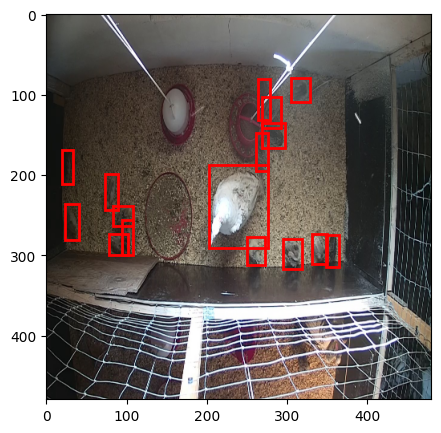

In [49]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()



# plotting the image with bboxes. Feel free to change the index
img, target = dataset_test[68]
print('EXPECTED OUTPUT')
plot_img_bbox(img, target)

In [43]:
from torchvision.transforms import ToTensor
# dataset = CustomDataset(files_dir, 224, 224)
dataset_test = CustomDataset(files_dir, 480, 480)
img, target = dataset_test[68]
# print(img.shape)
transform = ToTensor()
image_tensor = transform(img)

# Add a batch dimension to the tensor
image_tensor = image_tensor.unsqueeze(0)


with torch.no_grad():
    predictions = model(image_tensor)


MODEL OUTPUT


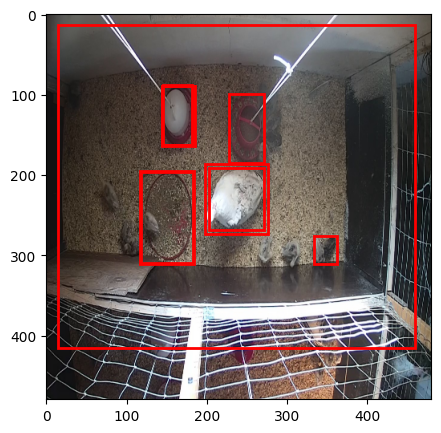

In [45]:
prediction = predictions[0]
prediction = {key: tensor.cpu() for key, tensor in prediction.items()}
print('MODEL OUTPUT')
plot_img_bbox(img, prediction)